In [110]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import scipy.stats as stats
import seaborn as sns
from math import ceil 

### Counting sample size

First, we would count the sample size needed for A/B Testing. The alpha = 0,2 and the performance rate is expected to increase from 13% into 14%. 

In [20]:
## Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.14,0.13) 

## Calculating sample size needed
required_n = sample_size = sms.NormalIndPower().solve_power(effect_size, power = 0.8, alpha = 0.2, ratio = 1)

## Sample size is up-rounded
required_n = ceil(required_n)
print(required_n)

10514


We need at least 10.514 observations for each group

### Preparing data

1. Download the dataset from Kaggle
2. Read the data into a pandas DataFrame
3. Check and clean the data as needed
4. Randomly sample n=4720 rows from the DataFrame for each group *

Step 4 is not necessary but it would be done for the sake of this project.

In [31]:
url = 'ab_data.csv'
df = pd.read_csv(url)
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [39]:
#check the datatypes
df.dtypes

#turn timestamp into datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
dtype: object

In [46]:
#check the count of 2 groups who see new_page and land_page
pd.crosstab(df['group'],df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


### Check multiple users

In [49]:
#count the occurence of each user_id
session_count = df['user_id'].value_counts()

#if user_id appears > 1, put it in the list of multiple users
multi_users = session_count[session_count > 1].count()

#print
print(f'there are {multi_users} people that appear multiple times in dataset')

there are 3894 people that appear multiple times in dataset


### Delete multiple users

In [68]:
users_to_drop = session_count[session_count > 1].index

#membuat dataframe baru dengan menghapus user yang double
df_new = df[~df['user_id'].isin(users_to_drop)]

print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 294478 entries


### Sampling

Now that our DataFrame is nice and clean, we can proceed and sample n=10.514 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us. 

Note: Set random_state = 22 so that the results are reproducible

In [86]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

#gabungkan control_sample dan treatment_sample
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,644179,2017-01-16 04:15:36.663685,control,old_page,0
1,729672,2017-01-20 19:04:10.409185,control,old_page,0
2,866186,2017-01-09 02:56:47.675707,control,old_page,0
3,884303,2017-01-18 04:49:04.225284,control,old_page,0
4,882576,2017-01-15 13:36:49.854723,control,old_page,0
...,...,...,...,...,...
21023,732045,2017-01-16 03:21:52.008259,treatment,new_page,0
21024,865191,2017-01-23 07:32:45.913986,treatment,new_page,0
21025,739004,2017-01-24 02:53:27.777595,treatment,new_page,0
21026,689953,2017-01-07 18:33:05.067482,treatment,new_page,0


In [88]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21028 entries, 0 to 21027
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       21028 non-null  int64         
 1   timestamp     21028 non-null  datetime64[ns]
 2   group         21028 non-null  object        
 3   landing_page  21028 non-null  object        
 4   converted     21028 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 821.5+ KB


In [90]:
ab_test['group'].value_counts()

control      10514
treatment    10514
Name: group, dtype: int64

### Visualizing the Results

Do some basic statistic to get an idea of the samples we have

In [100]:
conversion_rate = ab_test.groupby('group')['converted']

In [98]:
# make anon function of standar deviation (std_p) and standard error of the mean (se_p)
std_p = lambda x: np.std(x)
se_p = lambda x: stats.sem(x)

In [103]:
a = conversion_rate.agg([np.mean,std_p,se_p])

In [105]:
# change the column name
a.columns = ['conversion rate','standard deviation','standard error']
a

,conversion rate,standard deviation,standard error
group,,,
control,0.121172,0.326327,0.003183
treatment,0.118604,0.323322,0.003153


Turned out the two designs performed very similarly, with the old design performing slightly better, approx. 12.11% vs. 11.86% conversion rate.

Now we could plot the groups

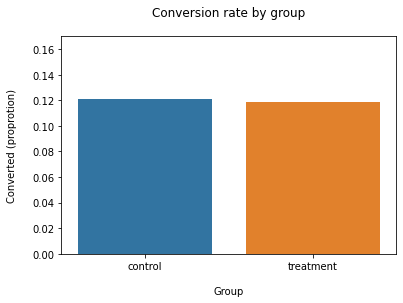

In [122]:
sns.barplot(x=ab_test['group'],y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group',labelpad=15)
plt.ylabel('Converted (proprotion)', labelpad=15);

So... the control group's value is higher. Is the difference statistically significant?

### Testing Hypothesis
The last step of our analysis is testing our hypothesis. Since we have a very large sample, we can use the normal approximation for calculating our p-value (i.e. z-test).

Again, Python makes all the calculations very easy. We can use the statsmodels.stats.proportion module to get the p-value and confidence intervals:

In [125]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [132]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [138]:
n_con = control_results.count()
n_treat = treatment_results.count()
success = [control_results.sum(),treatment_results.sum()]   #jumlah pembeli dari tiap group
nobs = [n_con, n_treat]                                     #the number of trials or observations, with the same length as count.

#### Hitung z_stat dan p-value

In [146]:
#statsmodels.stats.proportion.proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)
#output is test statistic for the z-test (z_stat) and p-value for the z-test (p_value)

z_stat, p_value = proportions_ztest(success, nobs)
z_stat, p_value

(0.573202812968297, 0.5665073799813036)

#### Hitung confidence interval for a binomial proportion

In [145]:
#statsmodels.stats.proportion.proportion_confint(count, nobs, alpha=0.05, method='normal')

(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(success, nobs, alpha = 0.05)
(lower_con, lower_treat), (upper_con, upper_treat)

((0.1149341808765732, 0.11242361748596227),
 (0.12740936106750136, 0.12478391532742938))

In [158]:
print(f'z statistic: {z_stat:.3f}')
print(f'p value: {p_value:.3f}')
print(f'ci 95% of control group: [{lower_con:.3f},{upper_con:.3f}]')
print(f'ci 95% of treatment group: [{lower_treat:.3f},{upper_treat:.3f}]')

z statistic: 0.573
p value: 0.567
ci 95% of control group: [0.115,0.127]
ci 95% of treatment group: [0.112,0.125]


### Drawing Conclusion

Since our p-value=0.567 is way above our alpha=0.2, we cannot reject the null hypothesis , which means that our new design did not perform significantly different (let alone better) than our old one :(

Additionally, if we look at the confidence interval for the treatment group ([0.112, 0.125], i.e. 11.2%-12.5%) we notice that:

It does not include our baseline value of 13% conversion rate
It does not include our target value of 14% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar (even slightly lower) to our baseline, rather than the 14% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board!